## Goals:
1. In addition to run length prediction, also do duration prediction
2. Compare to BOCD


## Next:
1. MOCA with prediction


In [1]:
import math
import numpy as np
import scipy.stats
from functools import partial

In [2]:
class BOCDSD(object):
    def __init__(self, hazard_function, observation_likelihood, dur_prob_dist_fn):
        """Initializes the detector with zero observations.
        """
        self.t0 = 0
        self.t = -1
        self.dur_prob_dist_fn = dur_prob_dist_fn
        self.max_dur = dur_prob_dist_fn.dur_max
        
        self.growth_probs = np.zeros((1,self.max_dur))
        self.growth_probs[0,:] = self.dur_prob_dist_fn.full_pdf()
        # Normalize matrix
        self.growth_probs = self.growth_probs/np.sum(self.growth_probs)
        
        self.hazard_function = hazard_function
        self.observation_likelihood = observation_likelihood
            
    def update(self, x):
        """Updates changepoint probabilities with a new data point.
        """
        self.t += 1

        t = self.t - self.t0
                
        # Create new array to hold new changepoint and duration probabilities
        new_growth_probs = np.zeros((t+2,self.max_dur))

        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        pred_probs = self.observation_likelihood.pdf(x)
        print(np.shape(pred_probs))
        
        
        # Evaluate probability that there WAS a changepoint
        # p(r_t+1 = 0 , d_t+1 = j+1) = 
        #                   SUM_over_k p(r_t = k, d_t = k+1)  ----- prior growth_probs
        #                            * p(x|r_t = k, d_t = k+1)  ----- pred_probs
        #                            * p(d_t+1 = j+1 | r_t+1 = 0, r_t = k, d_t = k+1) ---- dist from truncnorm
        #                            * p(r_t+1 = 0 | r_t = k, d_t = k+1) ---- equal to 1
        
        # Optional step to model a duration distribution after a changepoint:
        # Find most likely run length from previous steps
        most_likely_r = np.argmax(np.sum(self.growth_probs,1))
        # If most_likely_r is 0, default to the initial distribution and mean
        if most_likely_r == 0:
            dur_dist_after_cpt = self.dur_prob_dist_fn
        # OR set new mean to the most likely run length at this moment
        else:
            DUR_MIN = 1
            DUR_MAX = self.max_dur
            DUR_MEAN = most_likely_r + 1
            DUR_STD = self.dur_prob_dist_fn.dur_std
            dur_dist_after_cpt = TruncNormDist(DUR_MIN, DUR_MAX, DUR_MEAN, DUR_STD)
            
        for j in range(self.max_dur):
            p_r_update = 1. 
            # p_d_update = self.dur_prob_dist_fn.pdf(j+1) # pdf for duration = j+1  
            p_d_update = dur_dist_after_cpt.pdf(j+1) # pdf for duration = j+1                
            assert np.shape(self.growth_probs)[0] == np.shape(pred_probs)[0], "dims not compatible"
            assert np.size(np.diag(self.growth_probs)) == np.size(pred_probs[:self.max_dur]), "different lengths"
            fast_ans = p_r_update * p_d_update * np.sum(np.diag(self.growth_probs)*pred_probs[:self.max_dur])
            new_growth_probs[0,j] = fast_ans            
            
        
        # Evaluate probability that there wasn't a changepoint
        # p(r_t+1 = i , d_t+1 = j+1) = 
        #                    SUM_over_k p(r_t = i-1, d_t = k+1)  ----- prior growth_probs
        #                             * p(x|r_t = i-1, d_t = k+1)  ----- pred_probs
        #                             * p(d_t+1 = j+1 | r_t+1 = i, r_t = i-1, d_t = k+1) ---- dist from truncnorm (lower limit at i+1)
        #                             * p(r_t+1 = i | r_t = i-1, d_t = k+1) ---- equal to 1 only if k+1>i, i.e. k>i-1, else 0
        # NOT i = 0
        
        for i in range(1,min(t+2,self.max_dur)):
            p_r_update_fst = 1. 
            p_pred_fst = pred_probs[i-1] # run length = i-1, right now doesn't depend on duration
            p_joint_summed_fst = np.sum(self.growth_probs[i-1,i:self.max_dur]) # run length = i-1, duration = i+1 or greater)
            # Create a new truncnorm distribution with lower limit at i+1
            DUR_MIN = i+1
            DUR_MAX = self.max_dur
            DUR_MEAN = self.dur_prob_dist_fn.dur_mean + DUR_MIN
            DUR_STD = self.dur_prob_dist_fn.dur_std
            new_dur_dist_fn_fst = TruncNormDist(DUR_MIN, DUR_MAX, DUR_MEAN, DUR_STD)
            p_d_update_fst_vec = np.concatenate([np.zeros(i),new_dur_dist_fn_fst.full_pdf()])
            fast_ans_vec = p_r_update_fst * p_d_update_fst_vec * p_pred_fst * p_joint_summed_fst
            new_growth_probs[i,:] = fast_ans_vec
        
        # Put all the probabilities back inside self.growth_probs
        self.growth_probs = new_growth_probs
        
        # Renormalize
        if abs(np.sum(self.growth_probs) - 0) <0.001:
            print("Error at time",t," sum was close to 0 = ",np.sum(self.growth_probs))
        self.growth_probs = self.growth_probs/np.sum(self.growth_probs)

        # Update the parameter sets for each possible run length.
        self.observation_likelihood.update_theta(x)

    def prune(self, t0):
        """prunes memory before time t0. That is, pruning at t=0
        does not change the memory. One should prune at times
        which are likely to correspond to changepoints.
        """
        self.t0 = t0
        self.observation_likelihood.prune(self.t - t0 + 1)


In [3]:
class TruncNormDist:
    """Truncated normal distribution
    """
    def __init__(self, dur_min, dur_max, dur_mean, dur_std):
        self.dur_min = dur_min
        self.dur_max = dur_max
        self.dur_mean = dur_mean
        self.dur_std = dur_std
        alpha, beta = (dur_min - dur_mean) / dur_std, (dur_max - dur_mean) / dur_std
        self.alpha = alpha
        self.beta = beta

    def full_pdf(self):
        data = np.linspace(self.dur_min, self.dur_max, self.dur_max - self.dur_min +1)
        tbr = self.pdf(data)
        if np.size(tbr) == 1 and (tbr == 1.0 or tbr == 0.0):
            return [tbr]
        else:
            return tbr
        
    def pdf(self, data):
        """PDF of the predictive posterior.
        """
        if self.dur_min == self.dur_max:
            if data == self.dur_max:
                return 1.0
            else:
                return 0.0
        data_shift = (data - self.dur_mean)/self.dur_std
        return scipy.stats.truncnorm.pdf(data_shift, self.alpha, self.beta)

In [4]:
class StudentT:
    """Student's t predictive posterior.
    """
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        """PDF of the predictive posterior.
        """
        return scipy.stats.t.pdf(x=data,
                                 df=2*self.alpha,
                                 loc=self.mu,
                                 scale=np.sqrt(self.beta * (self.kappa+1) /
                                                  (self.alpha * self.kappa)))

    def update_theta(self, data):
        """Bayesian update.
        """
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) /
                                            (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0,
                                    self.beta +
                                    (self.kappa * (data - self.mu)**2) /
                                    (2. * (self.kappa + 1.))))

        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0
        
    def prune(self, t):
        """Prunes memory before t.
        """
        self.mu = self.mu[:t + 1]
        self.kappa = self.kappa[:t + 1]
        self.alpha = self.alpha[:t + 1]
        self.beta = self.beta[:t + 1]

# Generate data and plot

In [5]:
# Dataset 1
xs = np.random.normal(size=20)
xs[len(xs) // 4:len(xs) // 2] += 10.
xs[len(xs) // 2:3 * len(xs) // 4] -= 10. 
xs = xs/30
xs = xs +0.5

# Dataset 2
xs = np.random.normal(size=400)
xs[len(xs) // 4:len(xs) // 2] += 10.
xs[len(xs) // 2:3 * len(xs) // 4] -= 10. 
xs = xs/10
xs = xs +0.5

# Dataset 3
# xs = np.concatenate([0.5*np.ones(5), 0.8*np.ones(5), 0.1*np.ones(5), 0.7*np.ones(5)])

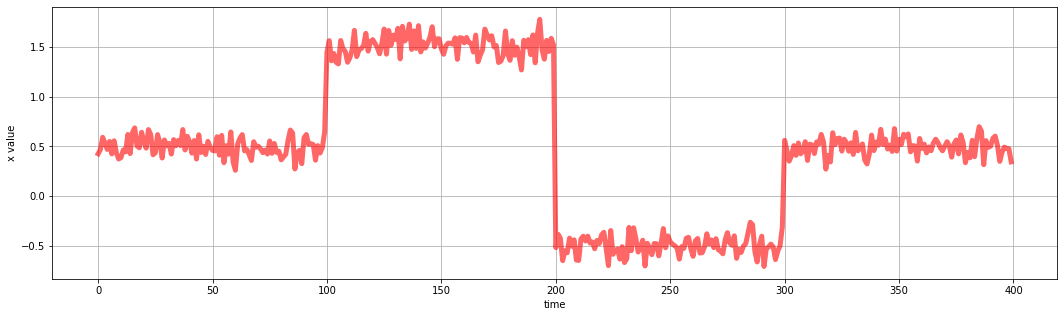

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
# plt.subplot(121)
plt.plot(xs,'r-', lw=5, alpha=0.6, label='t pdf')
plt.ylabel('x value')
plt.xlabel('time')
plt.grid('on')
plt.show()

# Initialize BOCPDSD

In [19]:
# Posterior prediction "Student T" distribution params
ALPHA = 0.1
BETA = 1.
KAPPA = 1.
MU = 0.

# Duration "truncated normal" distribution params
DUR_MIN = 1
DUR_MAX = 410
DUR_MEAN = 70.
DUR_STD = 20.

DELAY = 2
THRESHOLD = 0.5


hazard_placeholder = 0
bocdsd = BOCDSD(hazard_placeholder,
                StudentT(ALPHA, BETA, KAPPA, MU), 
                 TruncNormDist(DUR_MIN, DUR_MAX, DUR_MEAN, DUR_STD))


# Plot initial run length and duration beliefs

In [20]:
# Construct matrices for plotting
list_of_p_r_d = []
list_of_p_r_d.append(bocdsd.growth_probs)
T = np.shape(list_of_p_r_d)[0]
max_r = np.shape(list_of_p_r_d[-1])[0]
max_d = np.shape(list_of_p_r_d[-1])[1]
plot_mat = np.zeros((max_r,T))
plot_dur_mat = np.zeros((max_d,T))
for i in range(T):
    for j in range(max_r):
        if j>=np.shape(list_of_p_r_d[i])[0]:
            plot_mat[j,i] = 0.
        else:
            plot_mat[j,i] = np.sum(list_of_p_r_d[i][j,:])
    for k in range(max_d):
        if k>=np.shape(list_of_p_r_d[i])[1]:
            plot_dur_mat[k,i] = 0.
        else:
            plot_dur_mat[k,i] = np.sum(list_of_p_r_d[i][:,k])


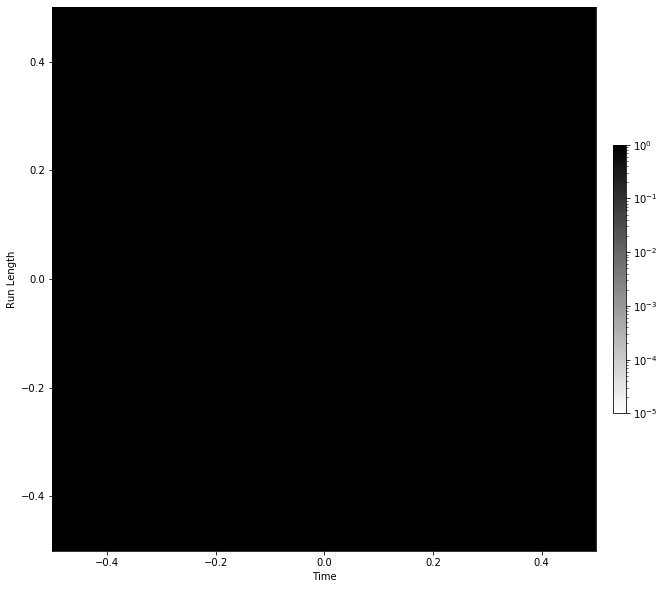

In [10]:
# Plot run length belief 
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
            
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

ax.invert_yaxis()
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

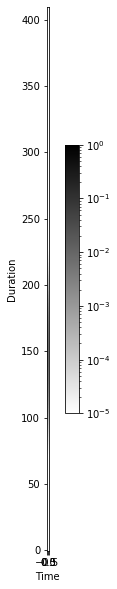

In [11]:
# Plot duration belief 
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
            
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(plot_dur_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

# ymax = 300
        
# for r in [250,500,750]:
#     ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

ax.invert_yaxis()
# ax.set_ylim((0,ymax))
ax.set_ylabel("Duration")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

# Plot initial duration probability distribution

3.1608234614692116e-12


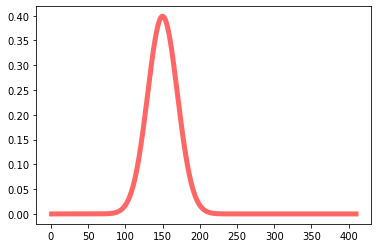

In [12]:
import matplotlib.pyplot as plt
dur_prob_dist_fn = bocdsd.dur_prob_dist_fn.full_pdf()
fig, ax = plt.subplots(1, 1)
x = np.linspace(DUR_MIN, DUR_MAX, DUR_MAX-DUR_MIN+1)
ax.plot(x, dur_prob_dist_fn,
       'r-', lw=5, alpha=0.6, label='truncnorm pdf')
print(bocdsd.dur_prob_dist_fn.pdf(7))

# Run BOCDSD on all the data

In [13]:
changepoints = []
list_of_p_r_d = []
for x_t in xs[:DELAY]:
    bocdsd.update(x_t)
    list_of_p_r_d.append(bocdsd.growth_probs)
    
for x_t in xs[DELAY:]:
    bocdsd.update(x_t)    
    if (abs(np.sum(bocdsd.growth_probs) -1)>0.0001):
        print("Error: Prob sum is not 1. Sum is", np.sum(bocdsd.growth_probs))
    list_of_p_r_d.append(bocdsd.growth_probs)
    if np.sum(bocdsd.growth_probs[DELAY,:]) >= THRESHOLD:
        changepoints.append(bocdsd.t - DELAY + 1)
        print("Changepoint found at ",changepoints[-1],"\n")

(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
(30,)
(31,)
(32,)
(33,)
(34,)
(35,)
(36,)
(37,)
(38,)
(39,)
(40,)
(41,)
(42,)
(43,)
(44,)
(45,)
(46,)
(47,)
(48,)
(49,)
(50,)
(51,)
(52,)
(53,)
(54,)
(55,)
(56,)
(57,)
(58,)
(59,)
(60,)
(61,)
(62,)
(63,)
(64,)
(65,)
(66,)
(67,)
(68,)
(69,)
(70,)
(71,)
(72,)
(73,)
(74,)
(75,)
(76,)
(77,)
(78,)
(79,)
(80,)
(81,)
(82,)
(83,)
(84,)
(85,)
(86,)
(87,)
(88,)
(89,)
(90,)
(91,)
(92,)
(93,)
(94,)
(95,)
(96,)
(97,)
(98,)
(99,)
(100,)
(101,)
Error at time 100  sum was close to 0 =  0.00010803674181862853
(102,)
Error at time 101  sum was close to 0 =  0.0001353235745815803
(103,)
(104,)
(105,)
(106,)
(107,)
(108,)
(109,)
(110,)
(111,)
(112,)
(113,)
(114,)
(115,)
(116,)
(117,)
(118,)
(119,)
(120,)
(121,)
(122,)
(123,)
(124,)
(125,)
(126,)
(127,)
(128,)
(129,)
(130,)
(131,)
(132,)
(133,)
(134,)
(135,)
(136,)
(137,)
(138,)
(139,)
(140,)
(

In [14]:
# import pickle
# with open('../pickles/data400horizon410mean70stddev20changingmean.pickle', 'wb') as f:
#     pickle.dump(list_of_p_r_d, f)

# Plot run length and duration beliefs

In [9]:
# import pickle
# with open('../pickles/data400horizon410mean70stddev20changingmean.pickle', 'rb') as f:
#     list_of_p_r_d = pickle.load(f)

In [15]:
# Construct matrices for plotting
T = np.shape(list_of_p_r_d)[0]
max_r = np.shape(list_of_p_r_d[-1])[0]
max_d = np.shape(list_of_p_r_d[-1])[1]
plot_mat = np.zeros((max_r,T))
plot_dur_mat = np.zeros((max_d,T))
for i in range(T):
    for j in range(max_r):
        if j>=np.shape(list_of_p_r_d[i])[0]:
            plot_mat[j,i] = 0.
        else:
            plot_mat[j,i] = np.sum(list_of_p_r_d[i][j,:])
    for k in range(max_d):
        if k>=np.shape(list_of_p_r_d[i])[1]:
            plot_dur_mat[k,i] = 0.
        else:
#             print(list_of_p_r_d[i][:,k])
            plot_dur_mat[k,i] = np.sum(list_of_p_r_d[i][:,k])


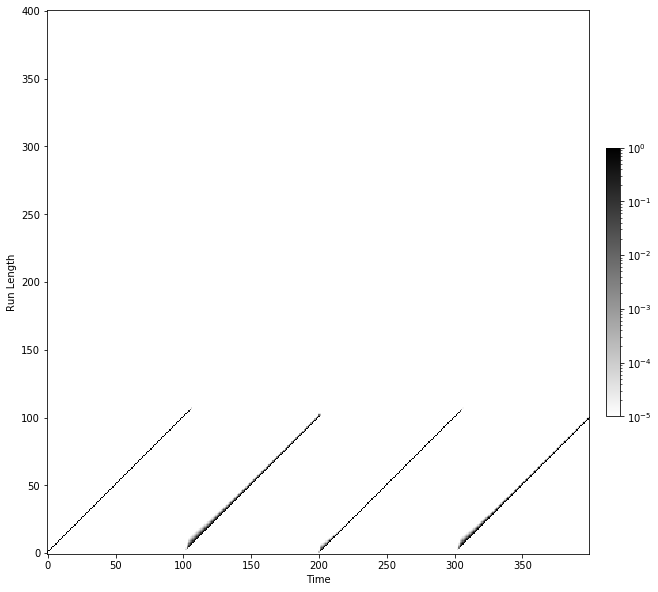

In [16]:
# Plot run length belief 
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
            
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

# ymax = 300
        
# for r in [250,500,750]:
#     ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

# ax.set_ylim((0,ymax))
ax.invert_yaxis()
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

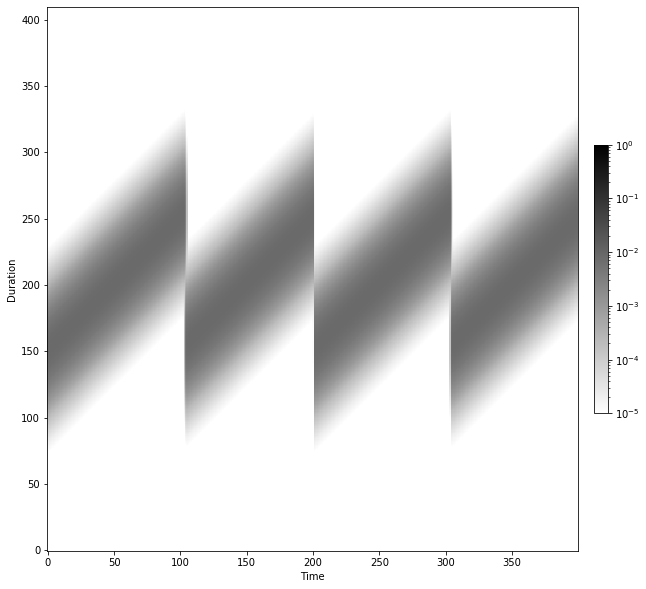

In [17]:
# Plot duration belief 
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
            
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(plot_dur_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

# ymax = 300
        
# for r in [250,500,750]:
#     ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

ax.invert_yaxis()
# ax.set_ylim((0,ymax))
ax.set_ylabel("Duration")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

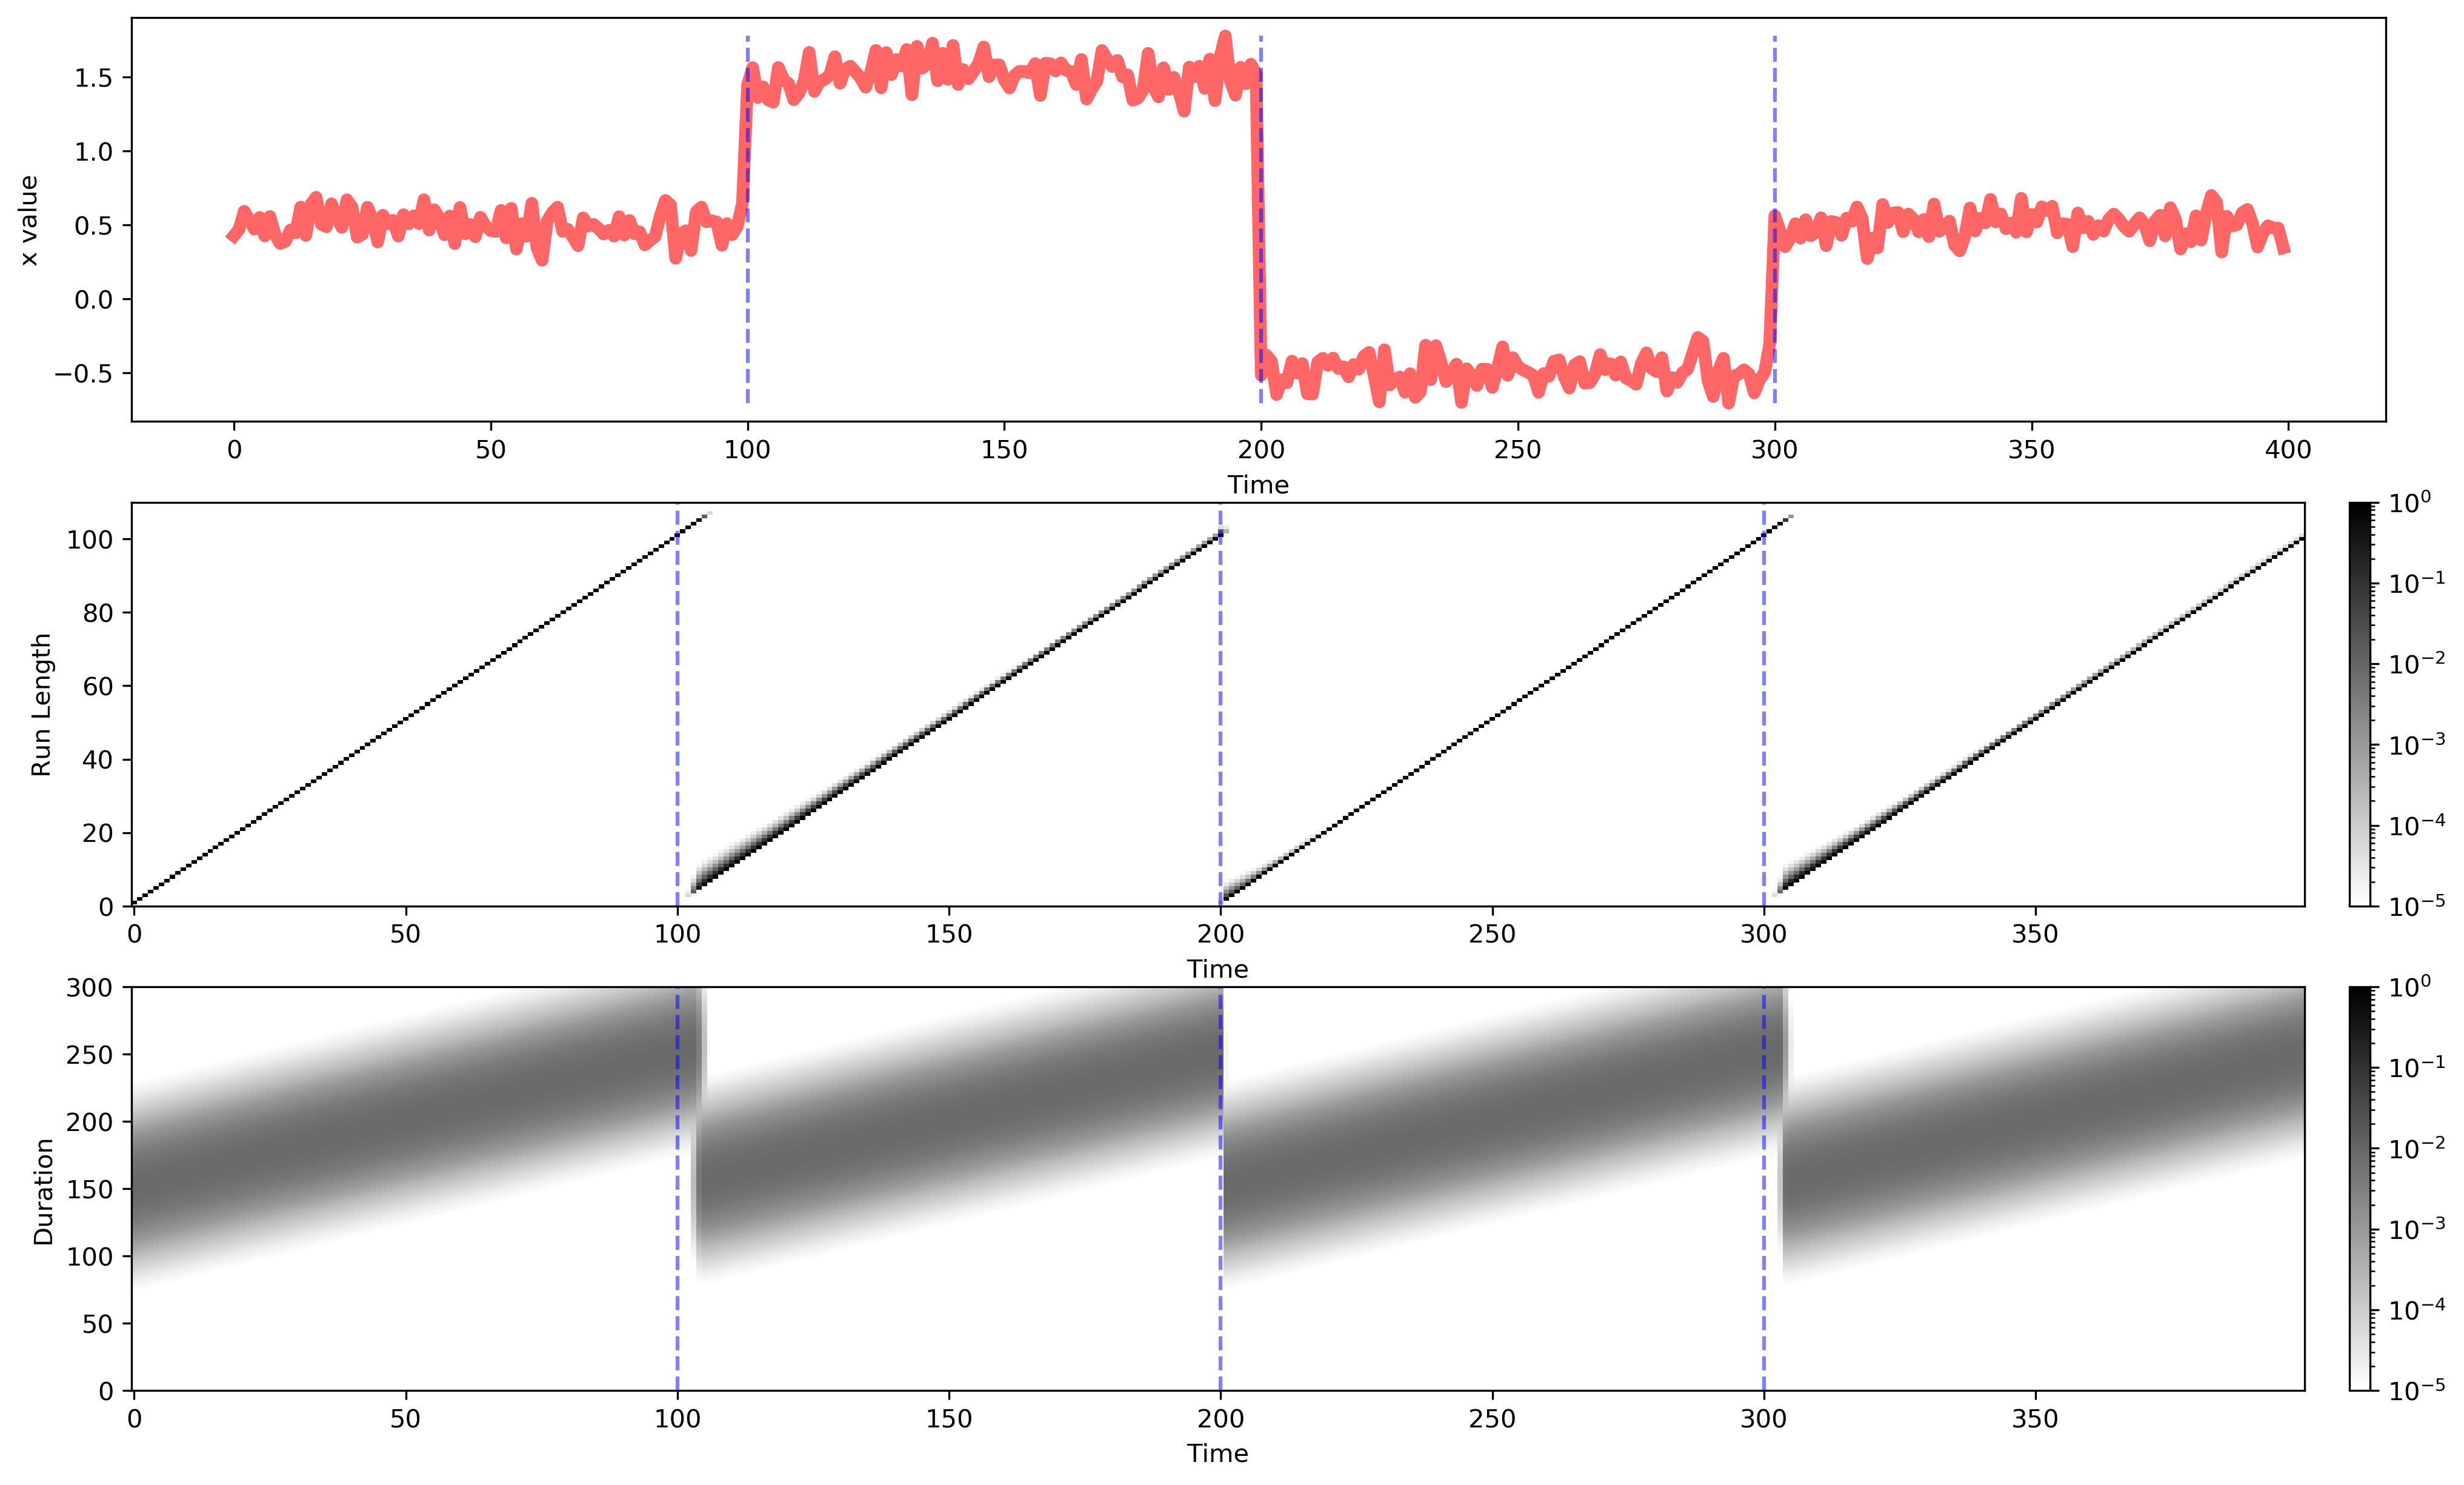

<Figure size 1800x1200 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

cpoints = [100, 200, 300]
ymax_run_length = 110
ymax_duration_length = 300

fig, axs = plt.subplots(3,1,figsize=(16, 10))

ax = axs[0]
ax.plot(xs,'r-', lw=5, alpha=0.6, label='t pdf')
for r in cpoints:
    ax.plot([r,r],[min(xs), max(xs)],'b',linestyle='--',alpha=0.5)
ax.set_ylabel('x value')
ax.set_xlabel('Time')

ax = axs[1]
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1),aspect='auto')
for r in cpoints:
    ax.plot([r,r],[0, ymax_run_length],'b',linestyle='--',alpha=0.5)
ax.invert_yaxis()
ax.set_ylim((0,ymax_run_length))
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

ax = axs[2]
ax.imshow(plot_dur_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1), aspect='auto')       
for r in cpoints:
    ax.plot([r,r],[0, ymax_duration_length],'b',linestyle='--',alpha=0.5)
ax.invert_yaxis()
ax.set_ylim((0,ymax_duration_length))
ax.set_ylabel("Duration")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

plt.savefig('../figures/duration_pred_step_400.png')


# Save and load to pickle

In [ ]:
# import pickle
# with open('../pickles/growthprobs.pickle', 'wb') as f:
#     pickle.dump(list_of_p_r, f)

In [23]:
# import pickle
# with open('../pickles/growthprobs.pickle', 'rb') as f:
#     list_of_p_r_d = pickle.load(f)